# Quantifying Pharmacy Deserts with Xarray-spatial

In this notebook, we'll demonstrate using Xarray-spatial to find and map the locations of pharmacy deserts in the USA.

### Setup:

First, we'll import some basic data and geospatial data-related packages. We'll also bring in some datashader functions for aggregation and rendering. And, finally, we'll import the Xarray-spatial functions we'll be using. 

In [1]:
import datashader as ds
from datashader.colors import inferno
from datashader.transfer_functions import set_background
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
import geopandas as gpd
import numpy as np
import pandas as pd
from spatialpandas import GeoDataFrame

from xrspatial import proximity
from xrspatial.classify import binary
from xrspatial.classify import natural_breaks

## Load data

Let's load up the data we'll be playing with today: US pharmacy facilities, US block group data, and a US counties shapefile.

To download the examples data, run the command `xrspatial examples` in your terminal. All the data will be stored in your current directory inside a folder named `xrspatial-examples`.

First, we'll create a DataFrame of pharmacy facility locations and clean that up a bit and set the coordinates.

In [2]:
# Load Pharmacies and add out x, y fields based on CalcLocation
pharmacy_df = pd.read_csv("./xrspatial-examples/data/facilities.csv")
coords = pharmacy_df["CalcLocation"].str.split(",", expand=True)
pharmacy_df["y"] = np.array(coords[0], dtype="float64")
pharmacy_df["x"] = np.array(coords[1], dtype="float64")
pharmacy_df

,CalcLocation,Name,Address,City,State,Zip,formated_phone,Status,Icon,Type,y,x
0,"32.32474700,-90.92676500",FMCNA - DELTA,104 RAILROAD AVE,DELTA,LA,71233,Please call patient admission line,open,small_green,Dialysis Center,32.324747,-90.926765
1,"46.00736300,-91.49085700",FMC - HAYWARD,10342 DYNO DR,HAYWARD,WI,54843,Please call patient admission line,open,small_green,Dialysis Center,46.007363,-91.490857
2,"34.79047900,-96.68271700",FMCNA - ADA DIALYSIS CTR,324 NW J.A. RICHARDSON LOOP,ADA,OK,74820,Please call patient admission line,open,small_green,Dialysis Center,34.790479,-96.682717
3,"38.92114100,-104.78556200",062563 LIBERTY DIALYSIS - COLORADO SPRINGS NOR...,2180 HOLLOWBROOK DR,COLORADO SPRINGS,CO,80918,Please call patient admission line,open,small_green,Dialysis Center,38.921141,-104.785562
4,"29.98721000,-95.49631600",CHAMPIONS DIALYSIS,4427 Cypress Creek Pkwy,HOUSTON,TX,77068,Please call patient admission line,open,small_green,Dialysis Center,29.987210,-95.496316
...,...,...,...,...,...,...,...,...,...,...,...,...
70713,"39.96783900,-75.20336900",Nextdoor Community Pharmacy,814 1/2 N 40th St,Philadelphia,PA,191044802,215-921-3191,open,small_green,Pharmacy,39.967839,-75.203369
70714,"40.52023400,-75.56858200",Macungie Community Pharmacy Inc,6465 Village Ln Ste 9,Macungie,PA,180628474,978-863-8342,not participating,measle_white,Pharmacy,40.520234,-75.568582
70715,"40.45670300,-79.92978000",Capsule Pharmacy,5846 Ellsworth Ave,Pittsburgh,PA,152321708,412-388-4918,not participating,measle_white,Pharmacy,40.456703,-79.929780
70716,"39.83663100,-75.44242700",Wellness Family Pharmacy,3250 Chichester Ave,Upper Chichester,PA,190613250,610-234-2922,open,small_green,Pharmacy,39.836631,-75.442427


Next, we'll do the same for the US block group data, but we'll use geopandas for this, because it involves spatial data.
We'll also group together all age groups above 65 to simplify things a bit. 

In [3]:
# Load Census Block Groups and Calculate Percent over 65 years-old
blockgroup_df = gpd.read_file("../xrspatial-examples/data/USA_Block_Groups.shp")
blockgroup_df = GeoDataFrame(blockgroup_df, geometry="geometry")
blockgroup_df["ABOVE_65"] = blockgroup_df[["AGE_65_74", "AGE_75_84", "AGE_85_UP"]].sum(
    axis=1
)
blockgroup_df["PCT_ABOVE_65"] = blockgroup_df["ABOVE_65"] / blockgroup_df["POP2010"]
blockgroup_df

,OBJECTID_1,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,BLKGRP,FIPS,POP2010,POP10_SQMI,...,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,geometry,ABOVE_65,PCT_ABOVE_65
0,1,0,48,167,48167,724101,1,481677241011,477,132.5,...,97,2.57,799,550,78,171,3.60,"MultiPolygon([[[-94.7372579289103, 29.32428411...",140,0.293501
1,2,1,48,245,48245,000600,6,482450006006,1260,6000.0,...,317,3.46,472,45,262,165,0.21,"MultiPolygon([[[-94.1277140349747, 30.12067592...",76,0.060317
2,3,2,48,167,48167,724300,5,481677243005,604,7550.0,...,123,3.07,424,139,87,198,0.08,"MultiPolygon([[[-94.7732350204798, 29.30697297...",60,0.099338
3,4,3,48,071,48071,710200,3,480717102003,5276,150.0,...,1455,3.41,1709,76,1548,85,35.18,"MultiPolygon([[[-94.7161589478771, 29.72786202...",218,0.041319
4,5,4,48,167,48167,724200,2,481677242002,906,11325.0,...,186,2.81,604,120,74,410,0.08,"MultiPolygon([[[-94.7696420580345, 29.31721401...",70,0.077263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219824,219827,219826,26,115,26115,990000,0,261159900000,0,0.0,...,0,0.00,0,0,0,0,0.19,"MultiPolygon([[[-83.3855070111396, 41.87580502...",0,NaN
219825,219828,219827,72,033,72033,990201,0,720339902010,-99,-99.0,...,-99,-99.00,-99,-99,-99,-99,0.00,"MultiPolygon([[[-66.1310319480659, 18.44882092...",-297,3.000000
219826,219829,219828,12,057,12057,990000,0,120579900000,0,0.0,...,0,0.00,0,0,0,0,1.79,"MultiPolygon([[[-82.4328329499806, 27.82253797...",0,NaN
219827,219830,219829,37,019,37019,990100,0,370199901000,0,0.0,...,0,0.00,0,0,0,0,0.56,"MultiPolygon([[[-78.4868539895199, 33.87145592...",0,NaN


And, we'll do the same again for the counties data.

In [4]:
# Load Census County and Calculate Percent over 65 years-old
county_df = gpd.read_file("../xrspatial-examples/data/USA_Counties.shp")
county_df = GeoDataFrame(county_df, geometry="geometry")
county_df["ZONE_ID"] = county_df["OBJECTID"].astype(np.int16)
county_df

,FID,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POPULATION,POP_SQMI,POP2010,...,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,Shape_Leng,SHAPE_Le_1,SHAPE_Area,geometry,ZONE_ID
0,1,1,Kauai,Hawaii,15,007,15007,73169,116.8,67091,...,591.0,244.0,30236.0,109160.0,626.57,2.938884,2.938884,0.141970,"MultiPolygon([[[-160.55047704799998, 21.653648...",1
1,2,2,Honolulu,Hawaii,15,003,15003,1014211,1681.1,953207,...,999.0,69.0,22200.0,161650.0,603.31,4.223576,4.223580,0.136184,"MultiPolygon([[[-178.33116966799997, 28.389919...",2
2,3,3,Hawaii,Hawaii,15,001,15001,204027,50.7,185079,...,4282.0,160.0,72028.0,57741.0,4027.83,5.616467,5.616467,0.898318,"MultiPolygon([[[-155.90856097299996, 19.181143...",3
3,4,4,Kalawao,Hawaii,15,005,15005,91,7.6,90,...,-99.0,-99.0,-99.0,-99.0,12.03,0.509271,0.509271,0.002709,"MultiPolygon([[[-156.92274293399998, 21.169214...",4
4,5,5,Maui,Hawaii,15,009,15009,169713,146.3,154834,...,1128.0,203.0,49578.0,166755.0,1159.64,6.359883,6.359882,0.260689,"MultiPolygon([[[-156.91562524699998, 21.172181...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,3216,3216,Aroostook,Maine,23,003,23003,70995,10.4,71870,...,895.0,392.0,187479.0,235215.0,6828.89,8.081154,8.081154,2.078769,"MultiPolygon([[[-69.20438401099995, 47.4523890...",3216
3216,3217,3217,Penobscot,Maine,23,019,23019,157026,44.2,153923,...,677.0,167.0,35578.0,74084.0,3556.09,6.546183,6.546183,1.058448,"MultiPolygon([[[-68.81933600499997, 46.3956810...",3217
3217,3218,3218,Piscataquis,Maine,23,021,23021,17258,3.9,17535,...,203.0,230.0,12387.0,0.0,4377.58,6.004977,6.004977,1.313017,"MultiPolygon([[[-69.72105006899994, 46.5738570...",3218
3218,3219,3219,Washington,Maine,23,029,23029,32358,11.7,32856,...,392.0,380.0,35706.0,394506.0,2757.41,17.906023,17.906018,0.815570,"MultiPolygon([[[-67.13363808099996, 45.1268899...",3219


## Define Study Area and aggregate:

Now we're ready to set up our aggregate rasters (data that's been aggregated into the regular row-column cell format of a raster image) and then perform calculations on those rasters and combine them in informative ways.

The first raster we'll set up is the counties mask; we'll use this one to make our other rasters fit with county shapes.

- We set a range for for our x and y coordinates in longitude and latitude values.
- We use datashader's Canvas object as an easy-to-use frame to build up a raster with and aggregate data into.
- Finally, we aggregate the county shapes - polygons - into that raster. 

A quick shade and transformation with datashader functions visualizes our mask set-up.

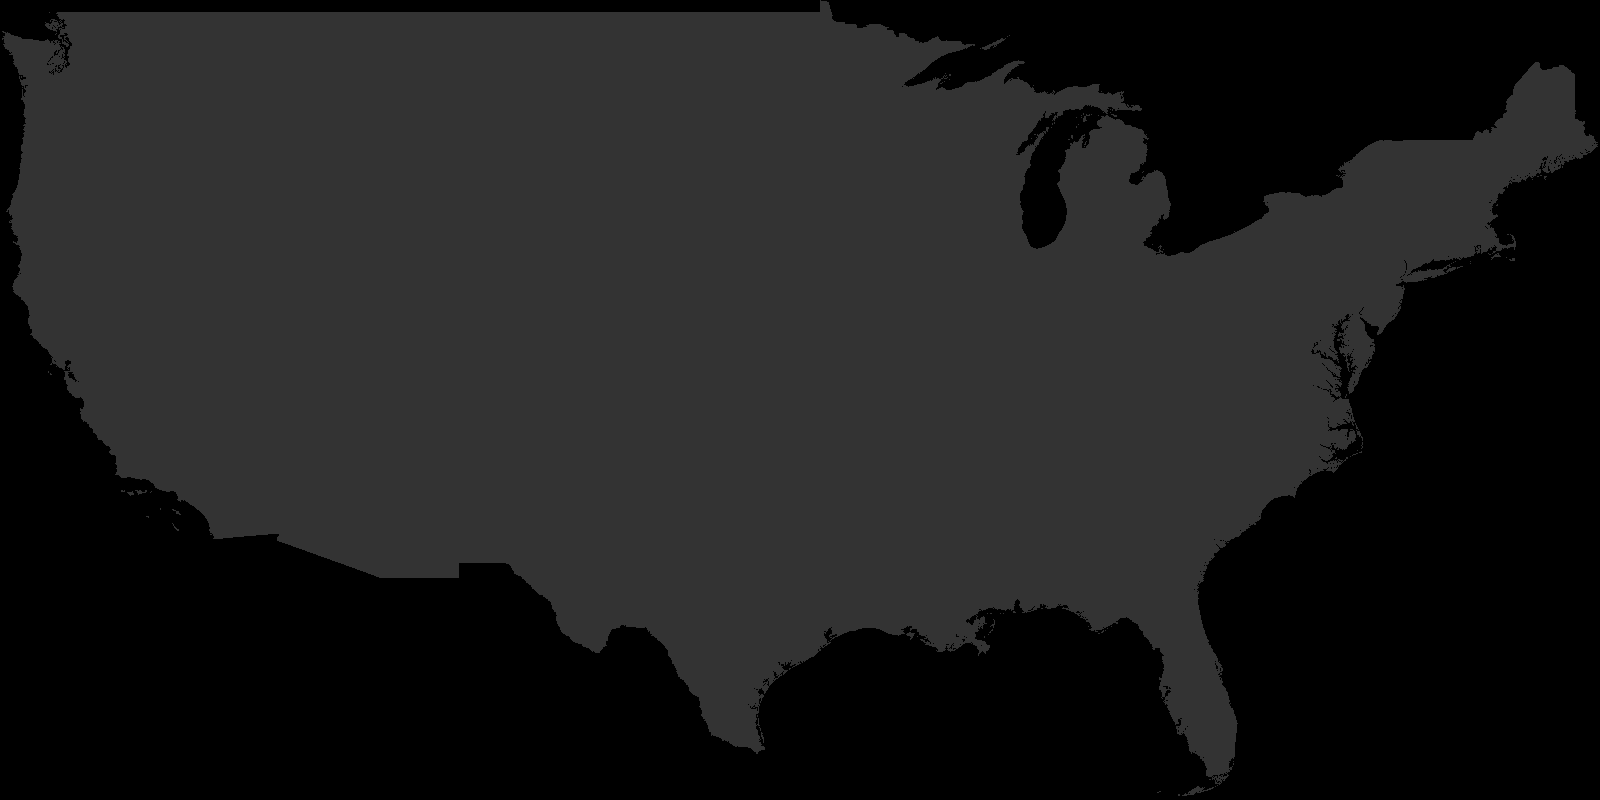

In [5]:
x_range = (-124.848974, -66.885444)
y_range = (24.396308, 49.384358)

W = 1600
H = 800

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=x_range, y_range=y_range)

county_mask = cvs.polygons(county_df, geometry="geometry")
set_background(shade(county_mask, cmap="#333333", alpha=255), "black")

Now we can set up the other rasters and use some Xarray-spatial functions to quantify pharmacy distances, age groups, and county data, and how they relate to each other.

### Create a "Distance to Nearest Pharmacy" Raster Layer & Classify into 4 Groups

First, we'll create a pharmacy locations raster layer by aggregating our pharmacies DataFrame from above.
Using `proximity`, we can create transform this into a raster of the distances for each point to its nearest pharmacy.
We can also further orgnaize this by applying Xarray-spatial's `natural_breaks` reclassification function. This will break up our proximity data into neat bins so it's easier to visualize and interpret.

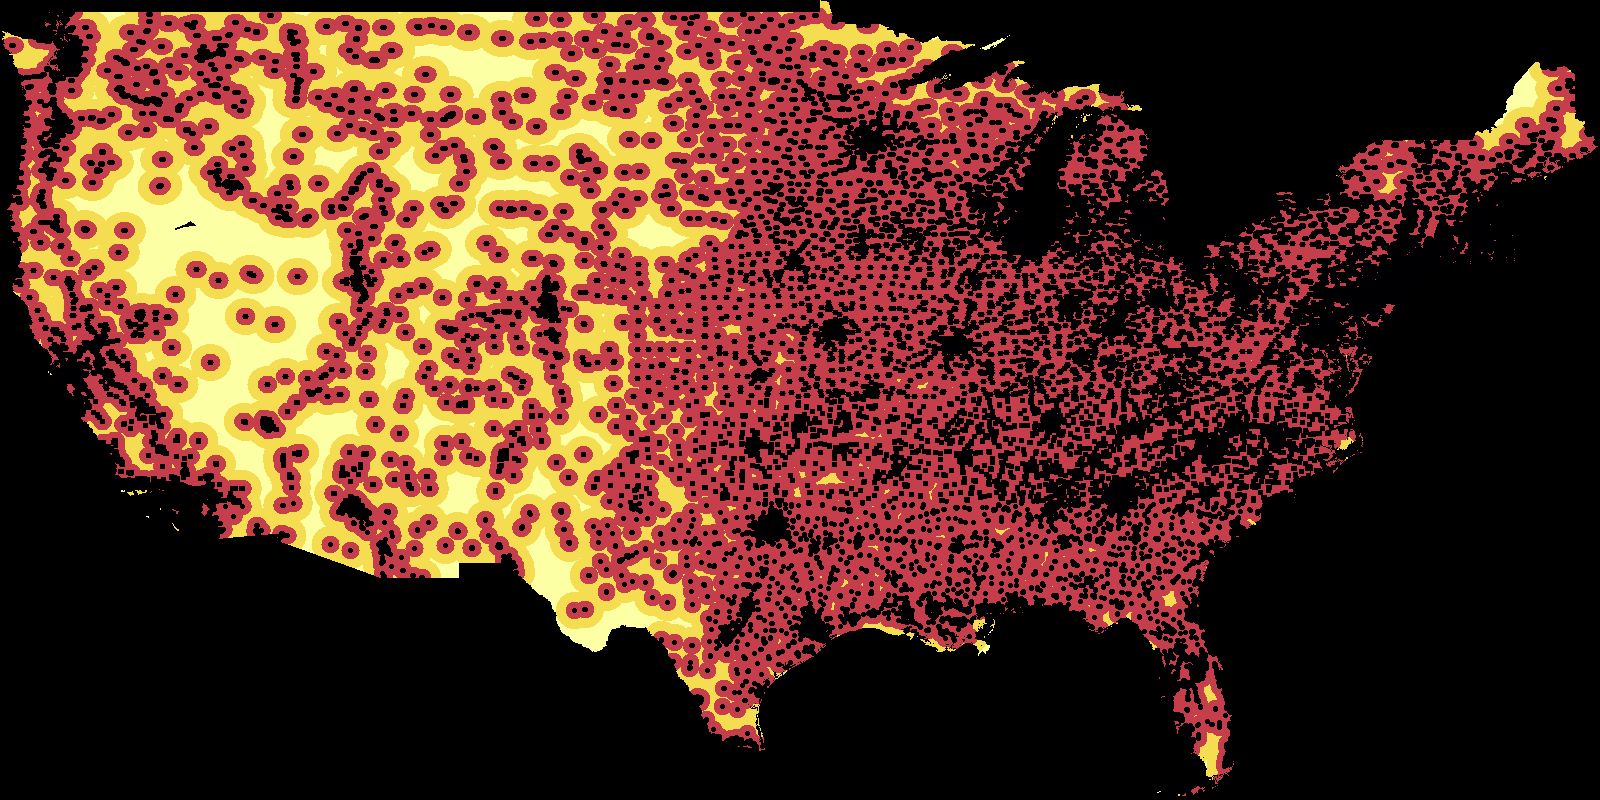

In [6]:
pharmacy_raster = cvs.points(pharmacy_df, "x", "y")
proximity_raster = proximity(pharmacy_raster, distance_metric="GREAT_CIRCLE").where(
    county_mask
)
proximity_raster.data[~np.isfinite(proximity_raster.data)] = 0.0

proximity_classifed = natural_breaks(proximity_raster, 20000, k=4).where(county_mask)

image_pharmacy = shade(proximity_classifed, cmap=inferno, alpha=255)
image_pharmacy = set_background(image_pharmacy, "black")
image_pharmacy

### Create an Age Layer  & Classify into 4 Groups

Next, we'll create an age groups raster from the block group DataFrame above.
We'll also reclassify this with `natural_breaks` to make it easier to map.

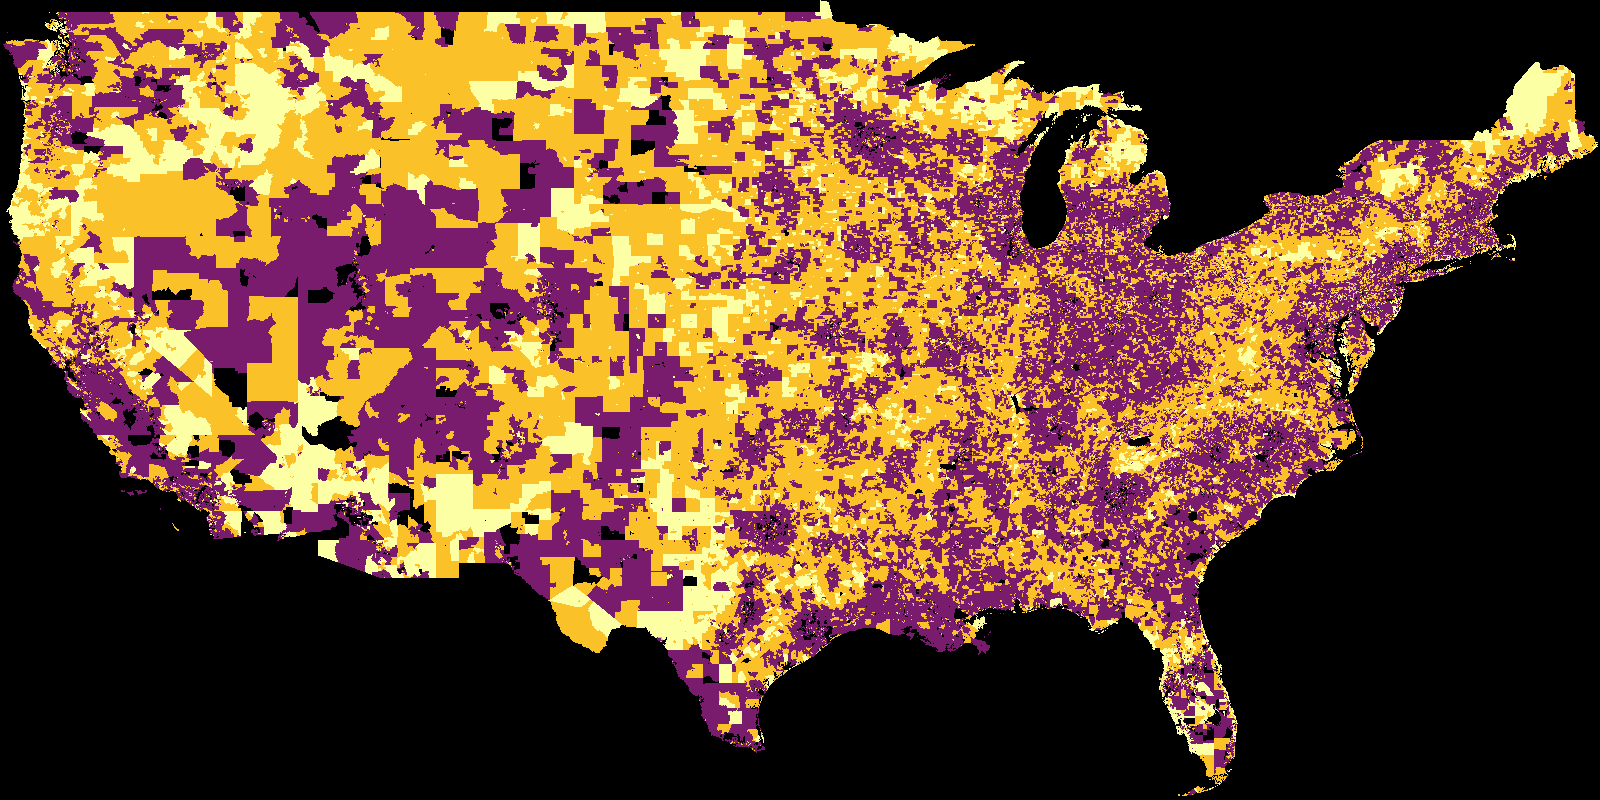

In [7]:
age_raster = cvs.polygons(
    blockgroup_df, geometry="geometry", agg=ds.mean("PCT_ABOVE_65")
)
age_raster.data[~np.isfinite(age_raster.data)] = 0.0

age_classifed = natural_breaks(age_raster, 20000, k=4).where(county_mask)

age_image = shade(age_classifed, cmap=inferno, alpha=255)
age_image = set_background(age_image, "black")
age_image

### Combine layers to highlight seniors at risk from pharmacy deserts

Finally, we'll combine the county, age, and pharmacy distance raster layers to highlight counties where there are more seniors who are at greater distance from pharmacies.

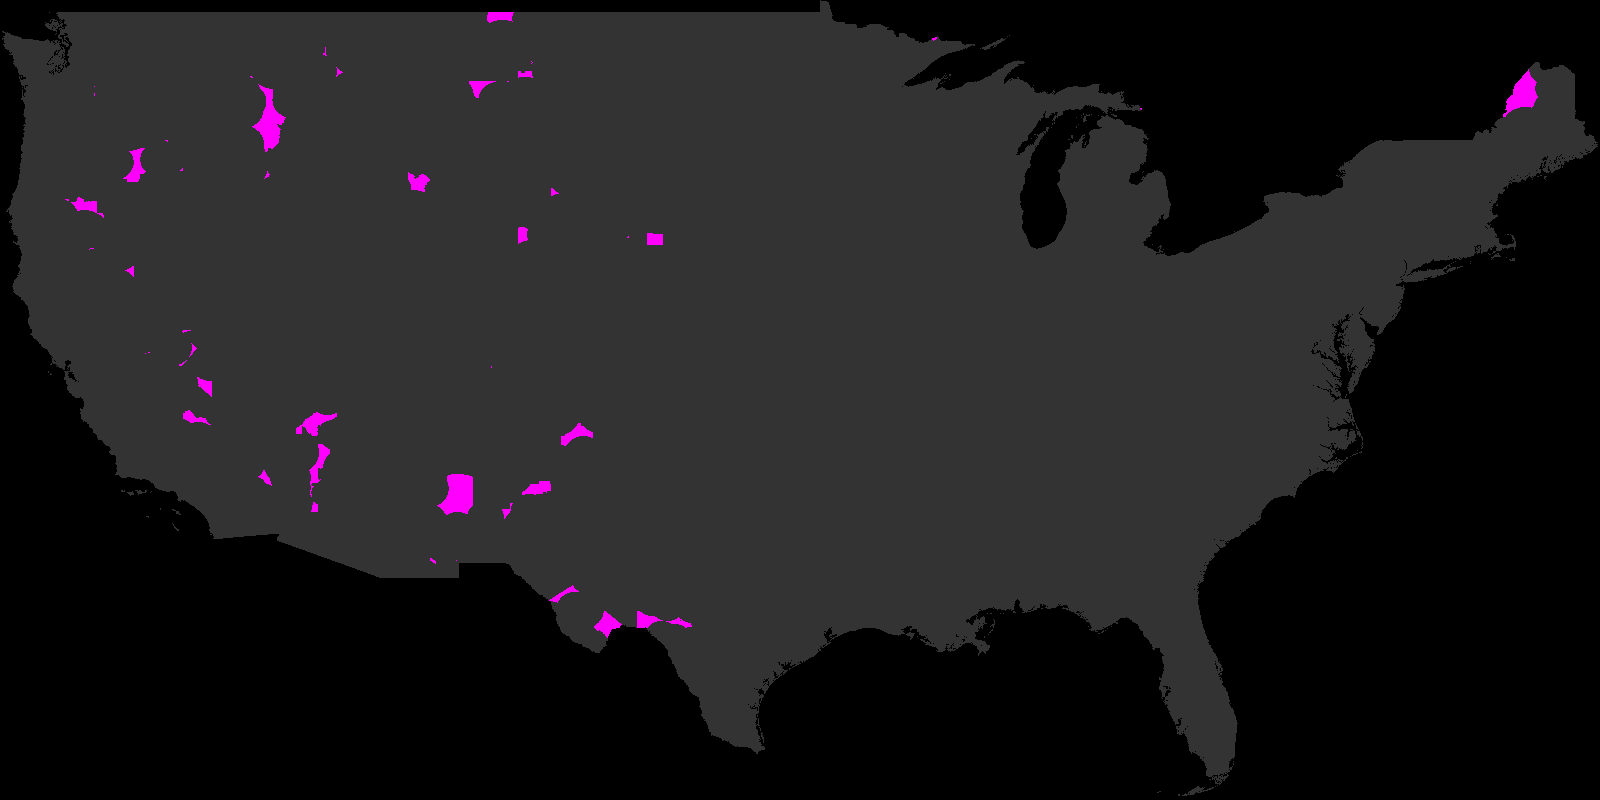

In [8]:
pharmacy_deserts = binary(proximity_classifed, [3])
older_regions = binary(age_classifed, [3])
target_deserts = (pharmacy_deserts * older_regions).where(county_mask)
target_deserts_img = shade(
    target_deserts, cmap=["#333333", "fuchsia"], alpha=255, how="linear"
)
set_background(target_deserts_img, "black")

###  Summarize seniors at risk by county: the Zonal Statistics function

The renderings above are great, but we might also want to summarize the quantitative info we just generated as a table with summary statistics. Xarray-spatial's zonal statisitics function lets us do that. 

`Zonal statistics` operates on a values raster by applying a zones aggregate to it. This is defined by creating an integer aggregate corresponding to the shape of the values raster, but with the value set at each cell to a non-zero integer that is the id of the zone we wish to put that cell in. `Zonal_stats` gathers the values for all cells assigned to each zone_id and generates summary statistics for each one. The output is a Pandas dataframe with the calculation results in columns and with a row for each zone.

#### Setup:

First, we'll set up our counties raster as a background for the statistics we're about to generate and shade with some fun colors just to take a look at it now (just because we want a table of values, doesn't mean we can't also visualize it if we like).

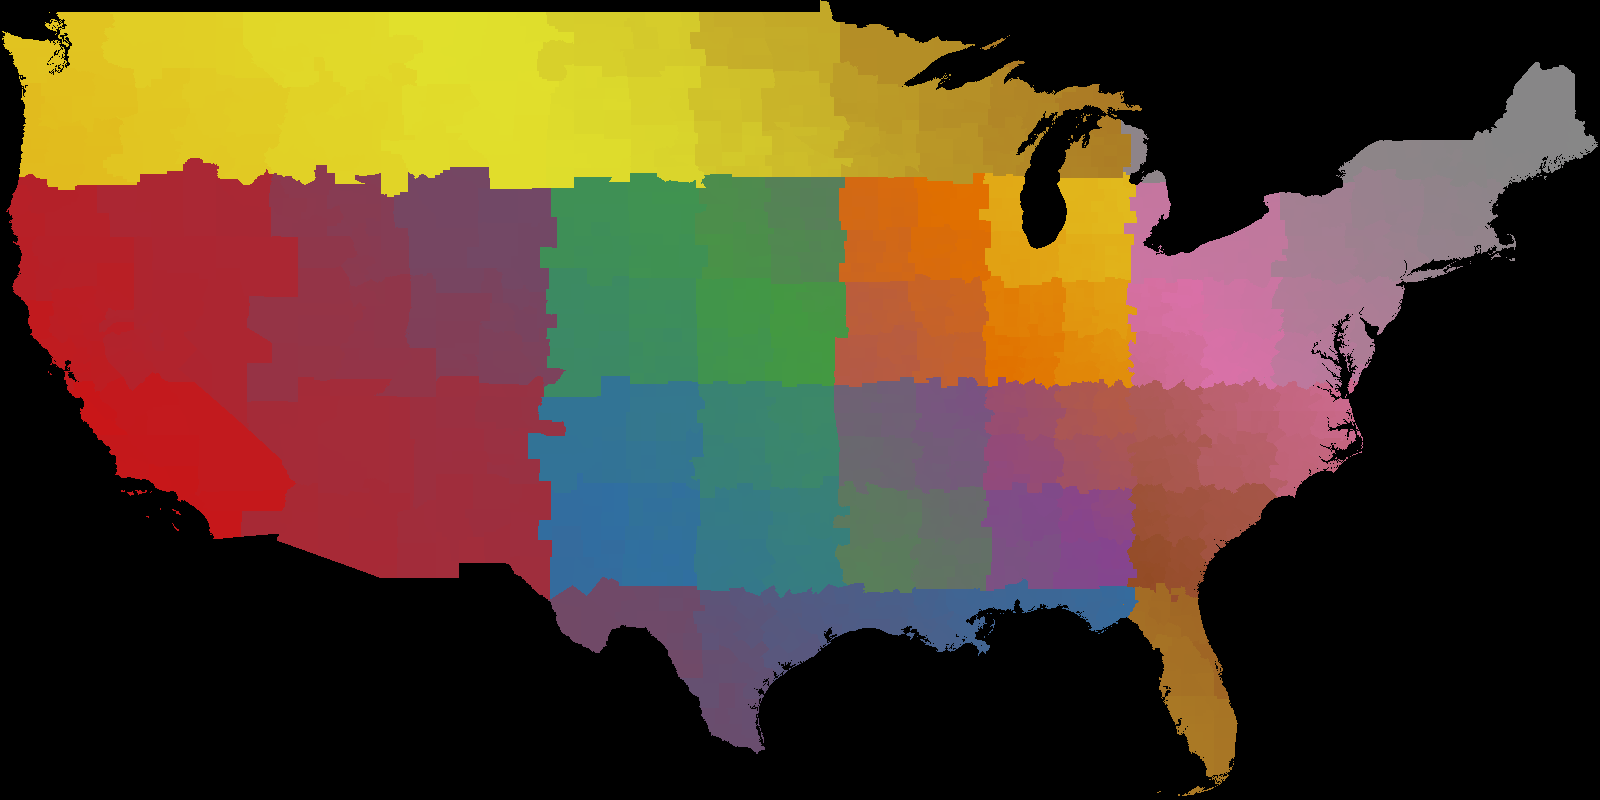

In [9]:
from datashader.colors import Set1

counties_raster = cvs.polygons(county_df, geometry="geometry", agg=ds.max("OBJECTID"))
counties_image = shade(counties_raster, cmap=Set1, alpha=225, how="linear")
set_background(counties_image, "black")

Now, let's generate those statistics.

After a quick clean-up, we'll put our rasters in as arguments: we put counties as the zones, put target deserts as the values  
to segregate into those zones, and provide a dict with our desired statistics function to perform.

Note: `zonal_stats` comes with its own set of default calculations it will perform if the 3rd "zonal_funcs" argument is left empty, and please do feel free to clear that out and see what happens.
But, for our purposes, all we need is a simple mean calculation, so we'll set that into a dict, which we'll put into zonal_stats.



In [10]:
from xrspatial import zonal_stats

# zones
counties_raster.data = counties_raster.data.astype(np.int64)

# values to summarize
target_deserts.data = target_deserts.data.astype(np.int8)

# summary functions
zonal_funcs = dict(pharmacy_desert_mean=lambda z: z.mean())

# execute summary functions on each zone and take top 10
results = zonal_stats(counties_raster, target_deserts, zonal_funcs)

Now we can merge this results DataFrame back into the original counties one. 

In [11]:
cols = ["pharmacy_desert_mean", "NAME", "STATE_FIPS", "geometry"]
final_df = pd.merge(county_df, results, left_on="ZONE_ID", right_index=True)[cols]
final_df.nlargest(10, "pharmacy_desert_mean")

,pharmacy_desert_mean,NAME,STATE_FIPS,geometry
752,1.000000,Hooker,31,"MultiPolygon([[[-100.84613006899997, 42.088166..."
137,0.651671,Catron,35,"MultiPolygon([[[-109.04615698099997, 34.579291..."
482,0.415449,Harding,35,"MultiPolygon([[[-104.00894199999999, 36.217891..."
267,0.337969,Val Verde,48,"MultiPolygon([[[-100.76184082899994, 29.237816..."
1953,0.301467,Idaho,16,"MultiPolygon([[[-114.59471401099995, 46.633533..."
1928,0.297789,Crook,41,"MultiPolygon([[[-120.38552699499996, 44.563954..."
261,0.283368,Jeff Davis,48,"MultiPolygon([[[-103.43997700399996, 30.665939..."
262,0.257919,Brewster,48,"MultiPolygon([[[-103.43997700399996, 30.665939..."
142,0.254795,Lincoln,35,"MultiPolygon([[[-105.31296907699999, 34.346719..."
3214,0.250464,Somerset,23,"MultiPolygon([[[-70.02247299099997, 46.5778160..."


Finally, we'll rasterize and shade these to visualize the results. We've highlighted the 100 counties with the highest pharmacy desert measures for seniors and shaded them by how much distance away, on average, the pharamcies are.

In [12]:
from xrspatial import hillshade

counties_raster = cvs.polygons(county_df, geometry="geometry", agg=ds.max("OBJECTID"))

desert_raster = cvs.polygons(
    final_df.nlargest(75, "pharmacy_desert_mean"),
    geometry="geometry",
    agg=ds.mean("pharmacy_desert_mean"),
)

county_mask = cvs.polygons(county_df, geometry="geometry")

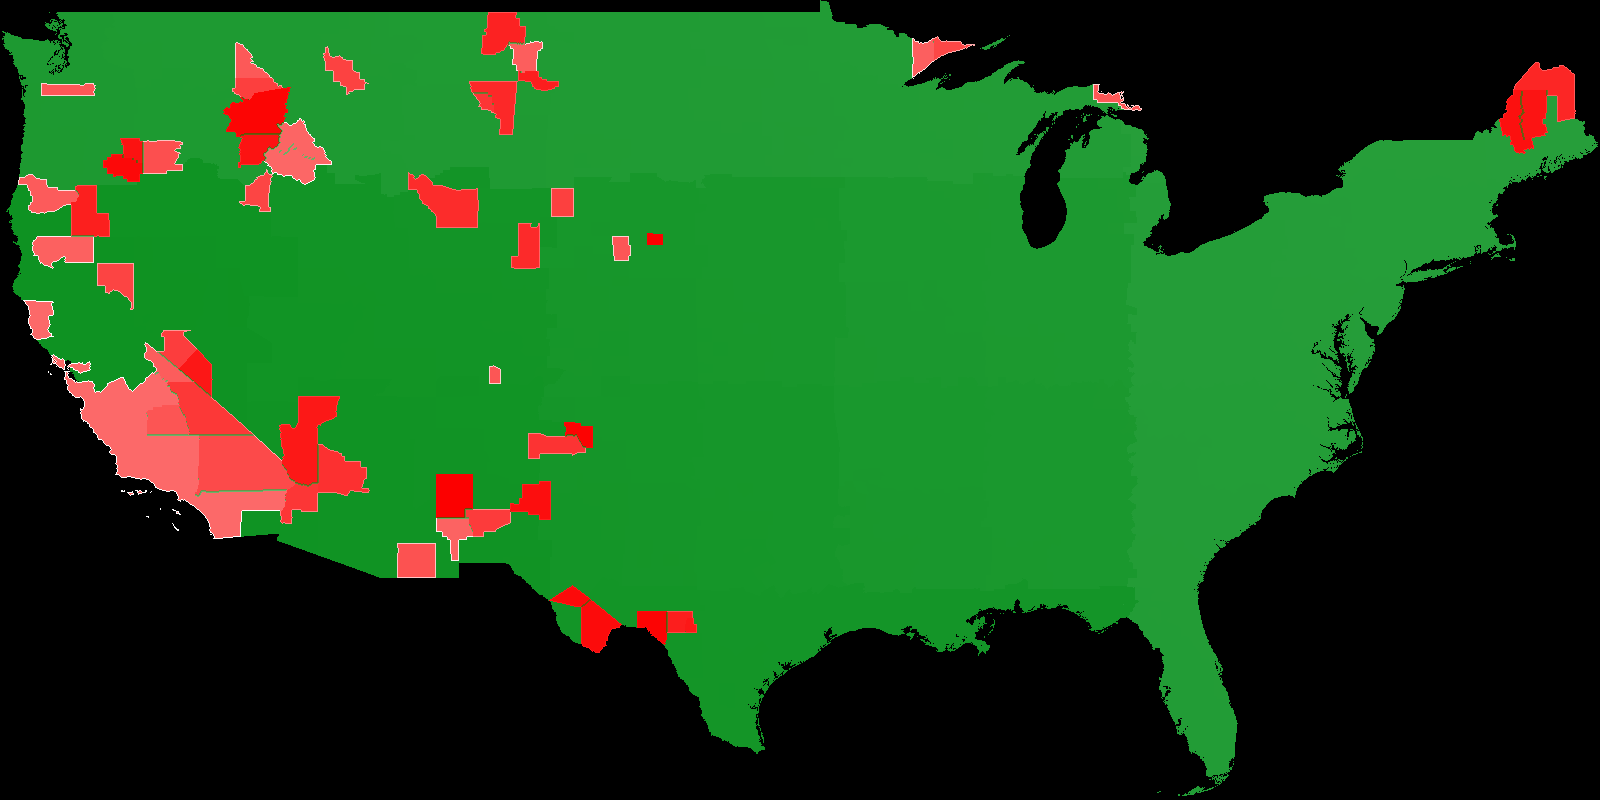

In [13]:
img = stack(
    shade(county_mask, cmap=["#0f9425"], alpha=255),
    shade(counties_raster, cmap=["green", "#ffffff"], alpha=25),
    shade(desert_raster, cmap=["white", "#ff0000"], alpha=255),
    shade(hillshade(desert_raster), cmap=["green", "#ff0000"], alpha=150),
)
set_background(img, "black")